In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load data
df = pd.read_excel('D:/KULIAH 2023/PENELITIAN/File/data_dbd_purwokerto_2022_2024.xlsx')

# Binarisasi target
df['Kasus DBD (0=Tidak, 1=Ya)'] = (df['Jumlah Kasus DBD'] > 5).astype(int)

# Fitur dan target
X = df[['Suhu (C)', 'Kelembaban (%)', 'Curah Hujan (mm)', 'Bulan']]
y = df['Kasus DBD (0=Tidak, 1=Ya)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fungsi evaluasi
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, class_report, conf_matrix

# Dictionary hasil
results = {}

# Tambah hasil ke dictionary
def add_class_report_to_results(model_name, accuracy, class_report, conf_matrix, results_dict):
    results_dict[model_name] = {
        "Accuracy": accuracy,
        "Precision (0)": class_report['0']['precision'] if '0' in class_report else 0,
        "Recall (0)": class_report['0']['recall'] if '0' in class_report else 0,
        "F1-Score (0)": class_report['0']['f1-score'] if '0' in class_report else 0,
        "Precision (1)": class_report['1']['precision'] if '1' in class_report else 0,
        "Recall (1)": class_report['1']['recall'] if '1' in class_report else 0,
        "F1-Score (1)": class_report['1']['f1-score'] if '1' in class_report else 0,
        "Macro Average Precision": class_report['macro avg']['precision'],
        "Macro Average Recall": class_report['macro avg']['recall'],
        "Macro Average F1-Score": class_report['macro avg']['f1-score'],
        "Confusion Matrix": conf_matrix
    }

# 1. SVM dengan class_weight balanced
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC(class_weight='balanced')
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
acc, rpt, cmx = evaluate_model(best_svm, X_train_scaled, X_test_scaled, y_train, y_test)
add_class_report_to_results('SVM Tuning', acc, rpt, cmx, results)

# 2. Logistic Regression (balanced)
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}
logreg_model = LogisticRegression(class_weight='balanced')
grid_search_logreg = GridSearchCV(logreg_model, param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train_scaled, y_train)
best_logreg = grid_search_logreg.best_estimator_
acc, rpt, cmx = evaluate_model(best_logreg, X_train_scaled, X_test_scaled, y_train, y_test)
add_class_report_to_results('Logistic Regression Tuning', acc, rpt, cmx, results)

# 3. Multinomial Naive Bayes (tanpa scaling)
mnb_model = MultinomialNB()
acc, rpt, cmx = evaluate_model(mnb_model, X_train, X_test, y_train, y_test)
add_class_report_to_results('Multinomial Naive Bayes', acc, rpt, cmx, results)

# Tampilkan hasil evaluasi
results_df = pd.DataFrame(results).T

# Pembulatan
results_df_rounded = results_df.copy()
for col in results_df_rounded.columns:
    if col != 'Confusion Matrix':
        results_df_rounded[col] = results_df_rounded[col].apply(lambda x: round(x, 2))

# Tampilkan tabel ringkasan
print("\n=== Hasil Evaluasi Model ===")
print(results_df_rounded.drop(columns='Confusion Matrix').to_string())

# Tampilkan Confusion Matrix masing-masing model
for model in results_df.index:
    print(f"\nConfusion Matrix untuk {model}:")
    conf_matrix = results_df.loc[model, 'Confusion Matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Prediksi: 0', 'Prediksi: 1'],
                yticklabels=['Aktual: 0', 'Aktual: 1'])
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.tight_layout()
    plt.show()

# Visualisasi Akurasi per model
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df_rounded.index, y=results_df_rounded['Accuracy'], palette='viridis')
plt.title('Akurasi Tiap Model (Setelah Tuning)')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1)

# Tambahkan label persentase akurasi
for i, acc in enumerate(results_df_rounded['Accuracy']):
    plt.text(i, acc + 0.02, f"{acc*100:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()

# ini baru yang pasti

import joblib
# Simpan model dan scaler terbaik setelah evaluasi
joblib.dump(best_svm, 'best_svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')





=== Hasil Evaluasi Model ===
                            Accuracy  Precision (0)  Recall (0)  F1-Score (0)  Precision (1)  Recall (1)  F1-Score (1)  Macro Average Precision  Macro Average Recall  Macro Average F1-Score
SVM Tuning                      0.82           0.97        0.81          0.88           0.46        0.86          0.60                     0.71                  0.83                    0.74
Logistic Regression Tuning      0.48           0.85        0.46          0.60           0.17        0.57          0.26                     0.51                  0.52                    0.43
Multinomial Naive Bayes         0.55           0.90        0.51          0.66           0.22        0.71          0.33                     0.56                  0.61                    0.49

Confusion Matrix untuk SVM Tuning:


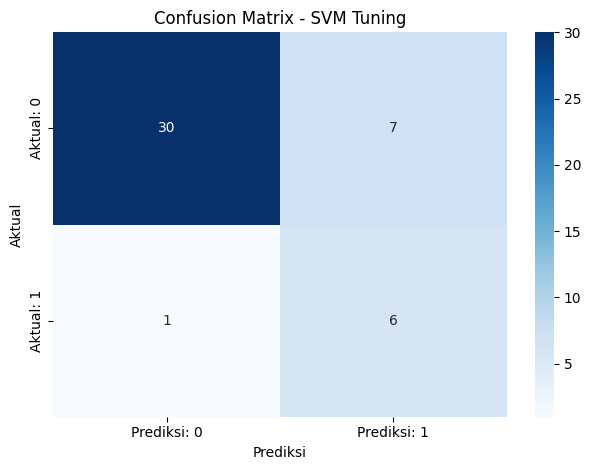


Confusion Matrix untuk Logistic Regression Tuning:


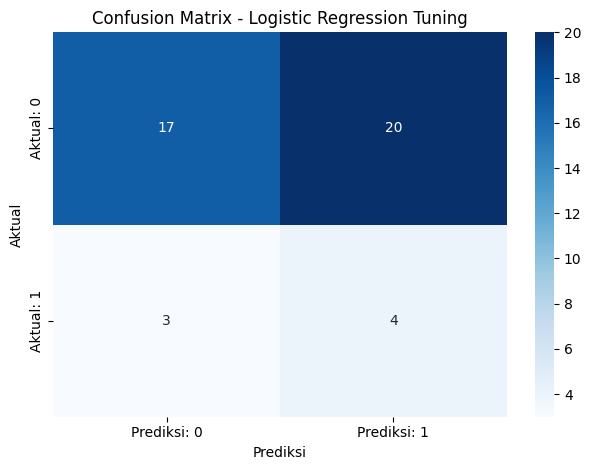


Confusion Matrix untuk Multinomial Naive Bayes:


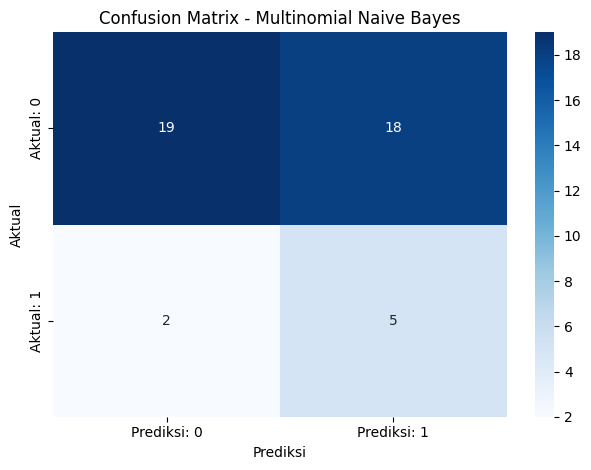

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_3580\2718118883.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df_rounded.index, y=results_df_rounded['Accuracy'], palette='viridis')


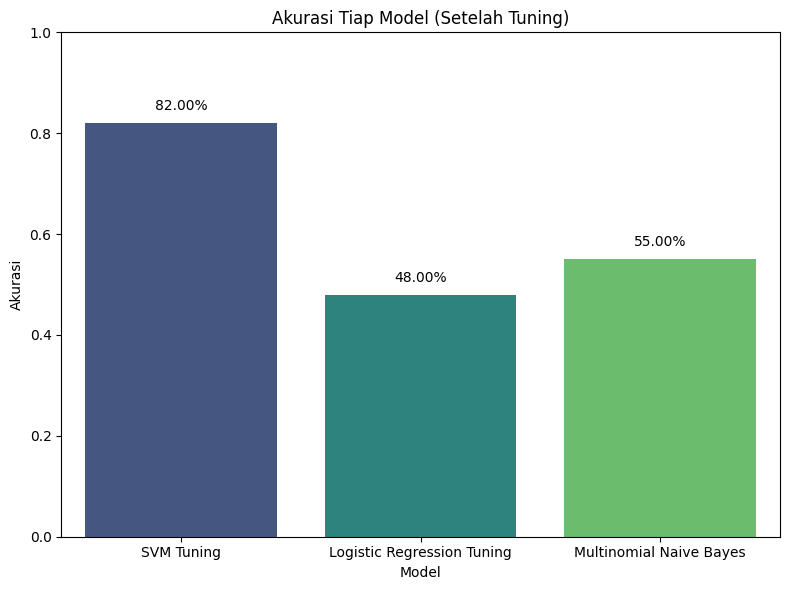

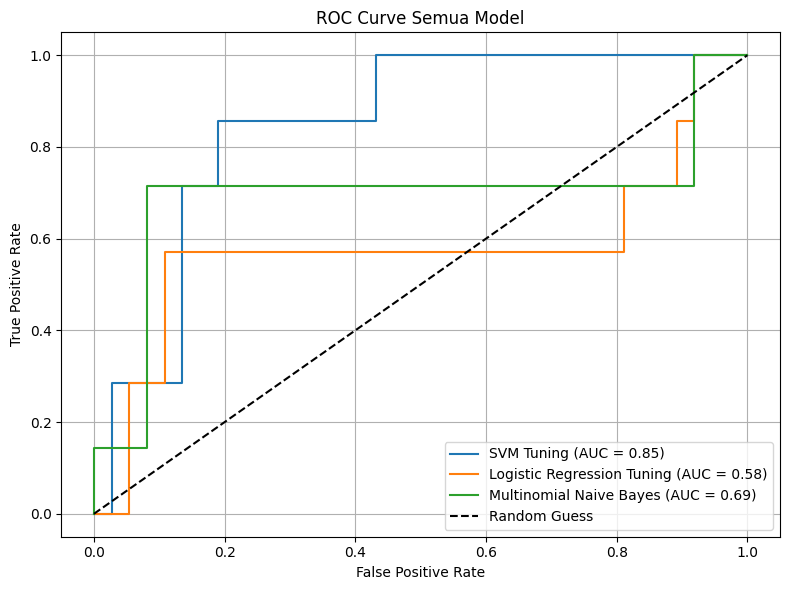

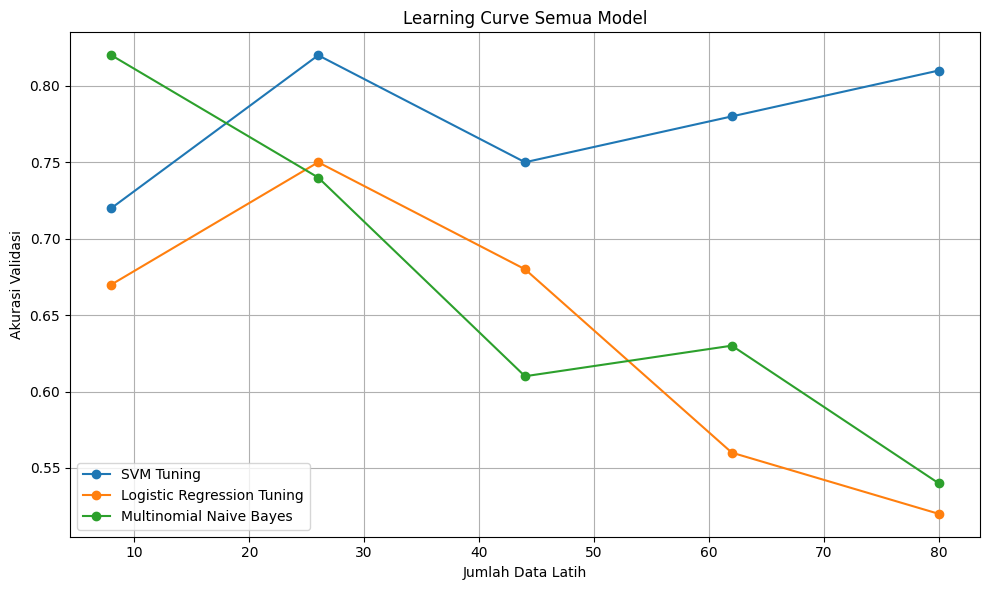

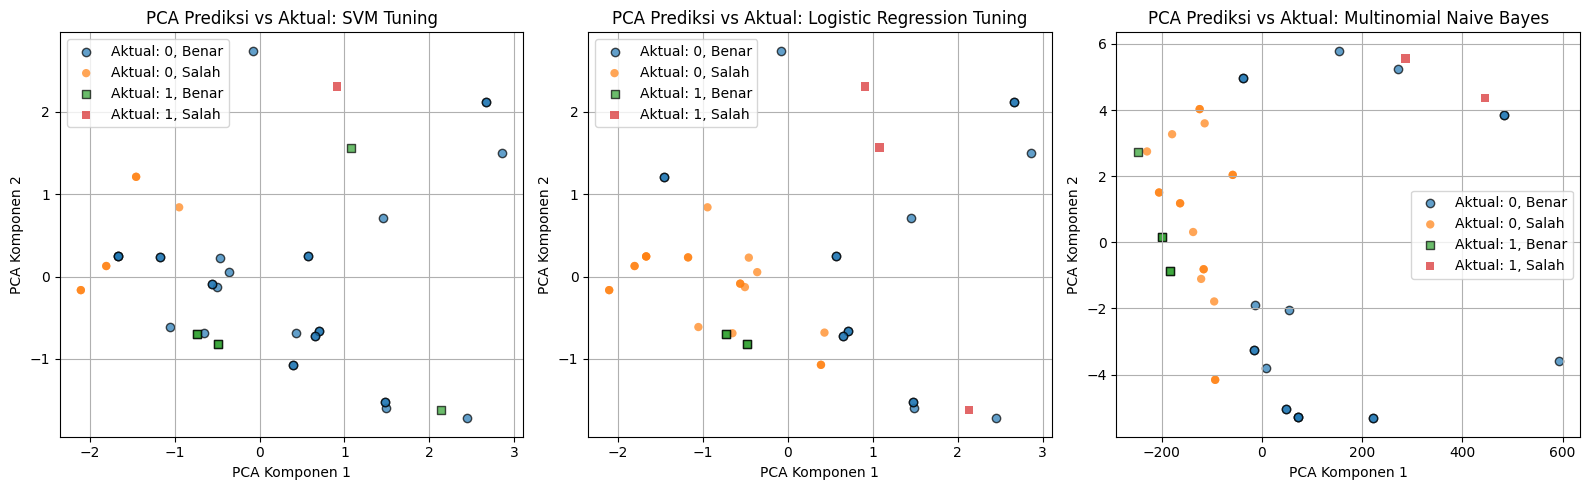

['scaler.pkl']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import joblib

# ==========================================
# 1. Load Data
# ==========================================
df = pd.read_excel('D:/KULIAH 2023/PENELITIAN/File/data_dbd_purwokerto_2022_2024.xlsx')

# Binarisasi target
df['Kasus DBD (0=Tidak, 1=Ya)'] = (df['Jumlah Kasus DBD'] > 5).astype(int)

# Fitur dan target
X = df[['Suhu (C)', 'Kelembaban (%)', 'Curah Hujan (mm)', 'Bulan']]
y = df['Kasus DBD (0=Tidak, 1=Ya)']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardisasi
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ==========================================
# 2. Fungsi Evaluasi
# ==========================================
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    return accuracy, class_report, conf_matrix

results = {}

def add_class_report_to_results(model_name, accuracy, class_report, conf_matrix, results_dict):
    results_dict[model_name] = {
        "Accuracy": accuracy,
        "Precision (0)": class_report['0']['precision'] if '0' in class_report else 0,
        "Recall (0)": class_report['0']['recall'] if '0' in class_report else 0,
        "F1-Score (0)": class_report['0']['f1-score'] if '0' in class_report else 0,
        "Precision (1)": class_report['1']['precision'] if '1' in class_report else 0,
        "Recall (1)": class_report['1']['recall'] if '1' in class_report else 0,
        "F1-Score (1)": class_report['1']['f1-score'] if '1' in class_report else 0,
        "Macro Average Precision": class_report['macro avg']['precision'],
        "Macro Average Recall": class_report['macro avg']['recall'],
        "Macro Average F1-Score": class_report['macro avg']['f1-score'],
        "Confusion Matrix": conf_matrix
    }

# ==========================================
# 3. Training dan Evaluasi Model
# ==========================================

# 1. SVM
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_model = SVC(class_weight='balanced', probability=True)
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='accuracy')
grid_search_svm.fit(X_train_scaled, y_train)
best_svm = grid_search_svm.best_estimator_
acc, rpt, cmx = evaluate_model(best_svm, X_train_scaled, X_test_scaled, y_train, y_test)
add_class_report_to_results('SVM Tuning', acc, rpt, cmx, results)

# 2. Logistic Regression
param_grid_logreg = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200]
}
logreg_model = LogisticRegression(class_weight='balanced')
grid_search_logreg = GridSearchCV(logreg_model, param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train_scaled, y_train)
best_logreg = grid_search_logreg.best_estimator_
acc, rpt, cmx = evaluate_model(best_logreg, X_train_scaled, X_test_scaled, y_train, y_test)
add_class_report_to_results('Logistic Regression Tuning', acc, rpt, cmx, results)

# 3. Multinomial Naive Bayes
mnb_model = MultinomialNB()
acc, rpt, cmx = evaluate_model(mnb_model, X_train, X_test, y_train, y_test)
add_class_report_to_results('Multinomial Naive Bayes', acc, rpt, cmx, results)

# ==========================================
# 4. Tabel Hasil Evaluasi
# ==========================================
results_df = pd.DataFrame(results).T

# Pembulatan
results_df_rounded = results_df.copy()
for col in results_df_rounded.columns:
    if col != 'Confusion Matrix':
        results_df_rounded[col] = results_df_rounded[col].apply(lambda x: round(x, 2))

# Tampilkan hasil
print("\n=== Hasil Evaluasi Model ===")
print(results_df_rounded.drop(columns='Confusion Matrix').to_string())

# Confusion Matrix Visual
for model in results_df.index:
    print(f"\nConfusion Matrix untuk {model}:")
    conf_matrix = results_df.loc[model, 'Confusion Matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Prediksi: 0', 'Prediksi: 1'],
                yticklabels=['Aktual: 0', 'Aktual: 1'])
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.tight_layout()
    plt.show()

# ==========================================
# 5. Visualisasi Akurasi
# ==========================================
plt.figure(figsize=(8, 6))
sns.barplot(x=results_df_rounded.index, y=results_df_rounded['Accuracy'], palette='viridis')
plt.title('Akurasi Tiap Model (Setelah Tuning)')
plt.xlabel('Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1)

for i, acc in enumerate(results_df_rounded['Accuracy']):
    plt.text(i, acc + 0.02, f"{acc*100:.2f}%", ha='center', va='bottom')

plt.tight_layout()
plt.show()


# ==========================================
# 6. ROC Curve dan AUC (Digabung)
# ==========================================
plt.figure(figsize=(8, 6))

for model_name in results_df.index:
    if model_name == 'SVM Tuning':
        model = best_svm
        X_test_data = X_test_scaled
    elif model_name == 'Logistic Regression Tuning':
        model = best_logreg
        X_test_data = X_test_scaled
    elif model_name == 'Multinomial Naive Bayes':
        model = mnb_model
        X_test_data = X_test

    # Cek apakah model mendukung probabilitas atau decision_function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_data)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test_data)
    else:
        print(f"Model {model_name} tidak mendukung ROC Curve.")
        continue

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")

# Tambahan visual
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve Semua Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


# ==========================================
# 7. Learning Curve (SVM)
# ==========================================

plt.figure(figsize=(10, 6))

models = {
    'SVM Tuning': best_svm,
    'Logistic Regression Tuning': best_logreg,
    'Multinomial Naive Bayes': mnb_model
}

for name, model in models.items():
    X_train_data = X_train_scaled if name != 'Multinomial Naive Bayes' else X_train
    y_train_data = y_train

    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_data, y_train_data, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1, random_state=42
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.plot(train_sizes, test_scores_mean, marker='o', label=name)

# ⬇️ Judul dan dekorasi dipanggil SETELAH plotting selesai
plt.title('Learning Curve Semua Model')
plt.xlabel('Jumlah Data Latih')
plt.ylabel('Akurasi Validasi')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



from sklearn.decomposition import PCA

# Buat objek PCA untuk reduksi ke 2 dimensi
pca = PCA(n_components=2)

plt.figure(figsize=(16, 5))
model_list = ['SVM Tuning', 'Logistic Regression Tuning', 'Multinomial Naive Bayes']

for i, model_name in enumerate(model_list, 1):
    if model_name == 'SVM Tuning':
        model = best_svm
        X_used = X_test_scaled
    elif model_name == 'Logistic Regression Tuning':
        model = best_logreg
        X_used = X_test_scaled
    elif model_name == 'Multinomial Naive Bayes':
        model = mnb_model
        X_used = X_test

    # PCA hanya dilakukan pada data ini
    X_pca = pca.fit_transform(X_used)

    # Prediksi dan akurat/tidak
    y_pred = model.predict(X_used)
    correct = y_pred == y_test.to_numpy()

    # Scatter plot
    plt.subplot(1, 3, i)
    for label in [0, 1]:
        for correctness in [True, False]:
            idx = (y_test == label) & (correct == correctness)
            plt.scatter(
                X_pca[idx, 0],
                X_pca[idx, 1],
                label=f"Aktual: {label}, {'Benar' if correctness else 'Salah'}",
                alpha=0.7,
                edgecolor='k' if correctness else 'none',
                marker='o' if label == 0 else 's'
            )

    plt.title(f'PCA Prediksi vs Aktual: {model_name}')
    plt.xlabel('PCA Komponen 1')
    plt.ylabel('PCA Komponen 2')
    plt.grid(True)
    plt.legend(loc='best')

plt.tight_layout()
plt.show()


# ==========================================
# 8. Simpan Model
# ==========================================
joblib.dump(best_svm, 'best_svm_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
